In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import statsmodels.formula.api as smf
import csv
from google.colab import files
import io
import pylab
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import seaborn as sns
import scipy
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
from scipy.stats import ks_2samp
cf.go_offline()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

#Load data and marge

##Load data

In [4]:
# Deaths
df_deaths = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/obitos_respiratorio.csv')

In [5]:
# Critical pollutions
df_MP10_Centro_raw = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/Gitti_JoãoVictor/Notebooks/Poluição/CSVs gerados - Critical Pollutions/Critical Pollution MP10_Centro.csv')
df_MP25_VUniao_raw = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/Gitti_JoãoVictor/Notebooks/Poluição/CSVs gerados - Critical Pollutions/Critical Pollution MP25_VUniao.csv')

## Merge datasets

In [6]:
df_MP10_Centro = df_MP10_Centro_raw.drop(columns = ['Unnamed: 0','DAY365','YEAR','above_pct'])
df_MP25_VUniao = df_MP25_VUniao_raw.drop(columns = ['Unnamed: 0','DAY365','YEAR','above_pct'])

In [7]:
df_MP10 = df_MP10_Centro.rename(columns={"PW":"Critical_Pollution"})
df_MP25 = df_MP25_VUniao.rename(columns={"PW":"Critical_Pollution"})

In [8]:
df_mp10_deaths_pollution = pd.merge(df_deaths,df_MP10,left_on = 'DTOBITO',right_on = 'DATE', how = 'inner')
df_mp25_deaths_pollution = pd.merge(df_deaths,df_MP25,left_on = 'DTOBITO',right_on = 'DATE', how = 'inner')

#Analysis

##Overall context for underlying cause from respiratory system

In [9]:
df_deaths_pollution_j = df_mp10_deaths_pollution[df_deaths['CID'].str.startswith('J')]
len(df_deaths_pollution_j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



63774

In [10]:
configure_plotly_browser_state()
init_notebook_mode(connected = False)

n_deaths_ICD = df_deaths_pollution_j['CID'].value_counts()
pct_deaths_ICD = (n_deaths_ICD * 100 )/ sum(n_deaths_ICD)
deaths_ICD = pd.concat([n_deaths_ICD, pct_deaths_ICD], axis=1).reset_index()
deaths_ICD.columns = ['ICD','Deaths','PCT']
deaths_ICD = deaths_ICD.set_index('ICD')
deaths_ICD[['Deaths']].iplot(kind="bar", title="Deaths per ICD", xTitle='ICD', yTitle='Number of deaths')

Output hidden; open in https://colab.research.google.com to view.

In [11]:
deaths_ICD.head()

,Deaths,PCT
ICD,,
J189,15394,24.138364
J180,12364,19.387211
J969,6781,10.632860
J81X,6339,9.939787
J960,5176,8.116160


Most frequent ICD underlying causes:

1. J189  - 24.1% - (Pneumonia não especificada)
2. J180  - 19.4% - (broncopneumonia não especificada)
3. J969  - 10.6% - (Insuficiência respiratória não especificada)
4. J81X  - 9.9% - (edema pulmonar não especificado)
5. J960  - 8.1% - (Insuficiência respiratória aguda)

###Distribution Info - MP10

In [12]:
def prepare_deaths_day_cp(df_deaths_pollution):

  df_datas_deaths = df_deaths_pollution[['DTOBITO']]
  df_n_deaths = pd.DataFrame(df_datas_deaths.groupby(['DTOBITO']).size())
  df_n_deaths = df_n_deaths.reset_index()

  df_pollution = df_deaths_pollution[['DTOBITO','Critical_Pollution']]
  df_pollution = pd.DataFrame(df_pollution.groupby(['DTOBITO']).mean())

  df_deaths_day_j = pd.merge(df_n_deaths, df_pollution, on='DTOBITO', how='inner')
  df_deaths_day_j = df_deaths_day_j.rename(columns={0:'Deaths','DTOBITO':'DATE'})

  return(df_deaths_day_j)

In [13]:
df_deaths_day_j = prepare_deaths_day_cp(df_mp10_deaths_pollution)

Shapiro-Wilk test of normality

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



Rejected Null hipotesis - data is not normally distributed



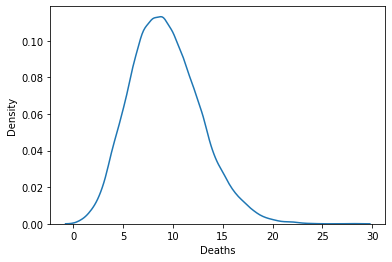

In [14]:
sns.distplot(df_deaths_day_j['Deaths'], hist=False, label='Death count')

alpha = 0.01
tes,p2 = shapiro(df_deaths_day_j['Deaths'])
if p2 > alpha:
	print('Null hipotesis - normal distribution\n')
else:
	print('Rejected Null hipotesis - data is not normally distributed\n')

Q-Q Plot for normality

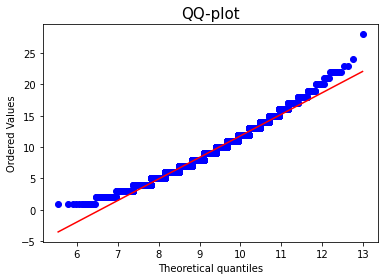

In [15]:
scipy.stats.probplot(df_deaths_day_j['Deaths'], df_deaths_day_j['Deaths'].mean(), dist="norm", plot=pylab)
pylab.title('QQ-plot',fontsize = 15)
pylab.show()

Points are not aligned -> We can officially reject null hypothesis.

Q-Q Plot for Poisson distribution

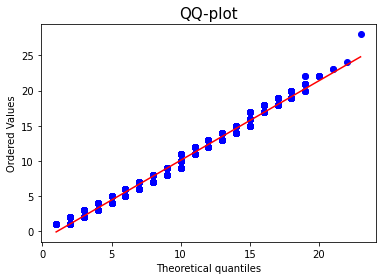

In [16]:
scipy.stats.probplot(df_deaths_day_j['Deaths'], df_deaths_day_j['Deaths'].mean(), dist="poisson", plot=pylab)
pylab.title('QQ-plot',fontsize = 15)
pylab.show()

#### Deaths and pollution division through time years

In [17]:
df_deaths_day_j['DATE'] = pd.to_datetime(df_deaths_day_j['DATE'])

In [18]:
info_years = df_deaths_day_j.groupby(df_deaths_day_j['DATE'].dt.year).sum()

In [19]:
# Command line to use .iplot
configure_plotly_browser_state()
init_notebook_mode(connected = False)

# Plot
info_years[['Deaths', 'Critical_Pollution']].iplot(kind="bar", title="Number of Deaths/Days above critical pollution per year(2001-2019)", xTitle='Year', yTitle='Number of deaths and number os days of critical pollution')

Output hidden; open in https://colab.research.google.com to view.

Deaths per Year Above Critical Pollution

In [20]:
# Create dataframe containing total deaths above CP per year
df_deaths_day_j_above_cp = df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 1]
info_years_above_cp = df_deaths_day_j_above_cp.groupby(df_deaths_day_j_above_cp['DATE'].dt.year).sum()

In [21]:
# Command line to use .iplot
configure_plotly_browser_state()
init_notebook_mode(connected = False)

# Plot
df = info_years_above_cp.reset_index()
fig = px.bar(df, y='Deaths', x='DATE', text='Deaths', title = 'Deaths on days above critical polution per year', labels={"DATE": "Year", "Deaths": "Number of Records"})
fig.update_traces(textposition='outside')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# Compare both dataset's death count above CP
info_years_above_cp = info_years_above_cp.reset_index()
deathcount_2001_2007 = info_years_above_cp[info_years_above_cp['DATE'] < 2010].Deaths.sum()
deathcount_2008_2019 = info_years_above_cp[info_years_above_cp['DATE'] >= 2010].Deaths.sum()
ds1_pct = round(deathcount_2001_2007 * 100 / (deathcount_2001_2007 + deathcount_2008_2019), 2)
ds2_pct = round(deathcount_2008_2019 * 100/ (deathcount_2001_2007 + deathcount_2008_2019), 2)
print("Number of Deaths above CP days 2001-2009: ", deathcount_2001_2007)
print("Number of Deaths above CP days 2010-2019: ", deathcount_2008_2019)
print("\nDeaths in Dataset 1 vs Total death count: ", ds1_pct,"%")
print("Deaths in Dataset 2 vs Total death count: ", ds2_pct,"%")

Number of Deaths above CP days 2001-2009:  2676
Number of Deaths above CP days 2010-2019:  588

Deaths in Dataset 1 vs Total death count:  81.99 %
Deaths in Dataset 2 vs Total death count:  18.01 %


### Hypothesis Test - MP10

Function to execute Mann-Whitney-U/Wilcoxon-Rank-sum and Kolmogorov-Smirnov (Two Sample) Tests for the selected dataframe having Number of Deaths per day and CP info

In [23]:
# parameter: obitos_dia_hw_IAC_x = dataframe containing both daily deaths and HW info
def stat_tests(obitos_dia_cp):
  sub_fora = obitos_dia_cp[obitos_dia_cp['Critical_Pollution'] == 0].Deaths
  sub_dentro = obitos_dia_cp[obitos_dia_cp['Critical_Pollution'] == 1].Deaths

  print('Mann-Whitney:')
  u_statistic1, p_value1 = mannwhitneyu(sub_fora,sub_dentro, alternative = 'two-sided')
  print('mannwhitneyu: U-statistic = %f\tp_value = %f' %(u_statistic1, p_value1))
  u_statistic2, p_value2 = ranksums(sub_fora,sub_dentro)
  print('ranksums: U-statistic = %f\tp_value = %f\n' %(u_statistic2, p_value2))

  print("Two Sample Kolmogorov-Smirnov:")
  u_statistic3, p_value3 = ks_2samp(sub_fora ,sub_dentro ,alternative='two-sided')
  print(f'p_value = {p_value3}')

  if (p_value1 < 0.05) or (p_value2 < 0.05) or (p_value3 < 0.05):
    print("\n\nPossible to reject Null hypothesis! According to: ")
    if (p_value1 < 0.05) or (p_value2 < 0.05):
      print(" - Mann-Whitney-U Test: ")
      if (p_value1 < 0.05):
        print("     mannwhitneyu")
      if (p_value2 < 0.05):
        print("     ranksums")
    if (p_value3 < 0.05):
      print(" - Two Sampe Kolmogorov-Smirnov Test")
  else:
    print("\n\nNo statistic significance to reject null hypothesis")

####Apply Tests on underlying cause ICD=J

In [24]:
print("Number of records for ICD=J: ", len(df_deaths_pollution_j))

Number of records for ICD=J:  63774


In [25]:
stat_tests(df_deaths_day_j)

Mann-Whitney:
mannwhitneyu: U-statistic = 1453229.000000	p_value = 0.000001
ranksums: U-statistic = 4.865024	p_value = 0.000001

Two Sample Kolmogorov-Smirnov:
p_value = 1.4768274697556538e-05


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [26]:
df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,6548.000000,6548.0
mean,9.313684,0.0
std,3.472198,0.0
min,1.000000,0.0
25%,7.000000,0.0
50%,9.000000,0.0
75%,12.000000,0.0
max,28.000000,0.0


In [27]:
df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,387.000000,387.0
mean,8.434109,1.0
std,3.343492,0.0
min,1.000000,1.0
25%,6.000000,1.0
50%,8.000000,1.0
75%,11.000000,1.0
max,20.000000,1.0


###Distribution Info - MP2.5

In [28]:
df_deaths_day_j = prepare_deaths_day_cp(df_mp25_deaths_pollution)

Shapiro-Wilk test of normality

Rejected Null hipotesis - data is not normally distributed



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



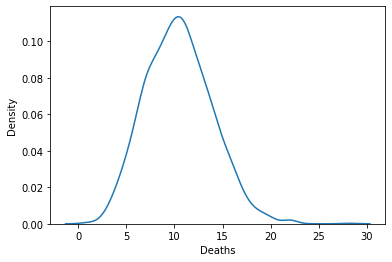

In [29]:
sns.distplot(df_deaths_day_j['Deaths'], hist=False, label='Death count')

alpha = 0.01
tes,p2 = shapiro(df_deaths_day_j['Deaths'])
if p2 > alpha:
	print('Null hipotesis - normal distribution\n')
else:
	print('Rejected Null hipotesis - data is not normally distributed\n')

Q-Q Plot for normality

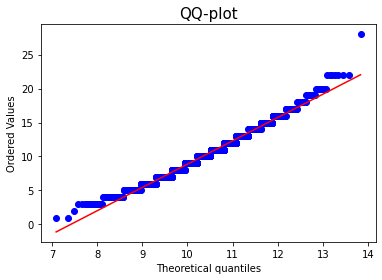

In [30]:
scipy.stats.probplot(df_deaths_day_j['Deaths'], df_deaths_day_j['Deaths'].mean(), dist="norm", plot=pylab)
pylab.title('QQ-plot',fontsize = 15)
pylab.show()

Points are not aligned -> We can officially reject null hypothesis.

Q-Q Plot for Poisson distribution

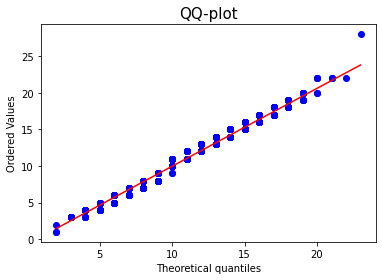

In [31]:
scipy.stats.probplot(df_deaths_day_j['Deaths'], df_deaths_day_j['Deaths'].mean(), dist="poisson", plot=pylab)
pylab.title('QQ-plot',fontsize = 15)
pylab.show()

####Deaths and pollution division through time years

In [32]:
df_deaths_day_j['DATE'] = pd.to_datetime(df_deaths_day_j['DATE'])

In [33]:
info_years = df_deaths_day_j.groupby(df_deaths_day_j['DATE'].dt.year).sum()

In [34]:
# Command line to use .iplot
configure_plotly_browser_state()
init_notebook_mode(connected = False)

# Plot
info_years[['Deaths', 'Critical_Pollution']].iplot(kind="bar", title="Number of Deaths/Days above critical pollution per year(2015-2019)", xTitle='Year', yTitle='Number of deaths and number os days of critical pollution')

Output hidden; open in https://colab.research.google.com to view.

Deaths per Year Above Critical Pollution

In [35]:
# Create dataframe containing total deaths above CP per year
df_deaths_day_j_above_cp = df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 1]
info_years_above_cp = df_deaths_day_j_above_cp.groupby(df_deaths_day_j_above_cp['DATE'].dt.year).sum()

In [36]:
# Command line to use .iplot
configure_plotly_browser_state()
init_notebook_mode(connected = False)

# Plot
df = info_years_above_cp.reset_index()
fig = px.bar(df, y='Deaths', x='DATE', text='Deaths', title = 'Deaths on days above critical polution per year', labels={"DATE": "Year", "Deaths": "Number of Records"})
fig.update_traces(textposition='outside')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [37]:
# Compare both dataset's death count above CP
info_years_above_cp = info_years_above_cp.reset_index()
deathcount_2015_2017 = info_years_above_cp[info_years_above_cp['DATE'] < 2017].Deaths.sum() + info_years_above_cp[info_years_above_cp['DATE'] == 2017].Deaths.sum() / 2
deathcount_2017_2019 = info_years_above_cp[info_years_above_cp['DATE'] > 2017].Deaths.sum() + info_years_above_cp[info_years_above_cp['DATE'] == 2017].Deaths.sum() / 2
ds1_pct = round(deathcount_2015_2017 * 100 / (deathcount_2015_2017 + deathcount_2017_2019), 2)
ds2_pct = round(deathcount_2017_2019 * 100/ (deathcount_2015_2017 + deathcount_2017_2019), 2)
print("Number of Deaths above CP days 2015-2017: ", deathcount_2015_2017)
print("Number of Deaths above CP days 2017-2019: ", deathcount_2017_2019)
print("\nDeaths in Dataset 1 vs Total death count: ", ds1_pct,"%")
print("Deaths in Dataset 2 vs Total death count: ", ds2_pct,"%")

Number of Deaths above CP days 2015-2017:  1397.0
Number of Deaths above CP days 2017-2019:  1696.0

Deaths in Dataset 1 vs Total death count:  45.17 %
Deaths in Dataset 2 vs Total death count:  54.83 %


###Hypothesis Test - MP 2.5

####Apply Tests on underlying cause ICD=J

In [38]:
df_deaths_pollution_j = df_mp25_deaths_pollution[df_deaths['CID'].str.startswith('J')]
len(df_deaths_pollution_j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



18939

In [39]:
print("Number of records for ICD=J: ", len(df_deaths_pollution_j))

Number of records for ICD=J:  18939


In [43]:
stat_tests(df_deaths_day_j)

Mann-Whitney:
mannwhitneyu: U-statistic = 180419.500000	p_value = 0.000046
ranksums: U-statistic = -4.060961	p_value = 0.000049

Two Sample Kolmogorov-Smirnov:
p_value = 0.0003245841078065581


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [44]:
df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1550.000000,1550.0
mean,10.321935,0.0
std,3.423078,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [45]:
df_deaths_day_j[df_deaths_day_j['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,275.000000,275.0
mean,11.247273,1.0
std,3.555188,0.0
min,3.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,22.000000,1.0


#####Stratification: Gender

In [46]:
df_deaths_cp_j_F = df_deaths_pollution_j[df_deaths_pollution_j['SEXO'] == 'F']
df_deaths_cp_j_M = df_deaths_pollution_j[df_deaths_pollution_j['SEXO'] == 'M']
n_j_F = len(df_deaths_cp_j_F)
n_j_M = len(df_deaths_cp_j_M)
print("Number of Female: ",n_j_F,"\nNumber of Male: ",n_j_M)

Number of Female:  9142 
Number of Male:  9797


**Tests for "Female" and "Male"**

In [47]:
df_deaths_day_j_F = prepare_deaths_day_cp(df_deaths_cp_j_F)
print("Female:")
stat_tests(df_deaths_day_j_F)
df_deaths_day_j_M = prepare_deaths_day_cp(df_deaths_cp_j_M)
print("\n\nMale:")
stat_tests(df_deaths_day_j_M)

Female:
Mann-Whitney:
mannwhitneyu: U-statistic = 188952.000000	p_value = 0.005694
ranksums: U-statistic = -2.739032	p_value = 0.006162

Two Sample Kolmogorov-Smirnov:
p_value = 0.018069773000884193


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


Male:
Mann-Whitney:
mannwhitneyu: U-statistic = 189241.000000	p_value = 0.008789
ranksums: U-statistic = -2.599193	p_value = 0.009344

Two Sample Kolmogorov-Smirnov:
p_value = 0.03325799808288532


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [48]:
df_deaths_day_j_F[df_deaths_day_j_F['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1533.000000,1533.0
mean,4.995434,0.0
std,2.250177,0.0
min,1.000000,0.0
25%,3.000000,0.0
50%,5.000000,0.0
75%,7.000000,0.0
max,15.000000,0.0


In [49]:
df_deaths_day_j_F[df_deaths_day_j_F['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,275.000000,275.0
mean,5.396364,1.0
std,2.237533,0.0
min,1.000000,1.0
25%,4.000000,1.0
50%,5.000000,1.0
75%,7.000000,1.0
max,12.000000,1.0


In [50]:
df_deaths_day_j_M[df_deaths_day_j_M['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1538.000000,1538.0
mean,5.341352,0.0
std,2.365688,0.0
min,1.000000,0.0
25%,4.000000,0.0
50%,5.000000,0.0
75%,7.000000,0.0
max,14.000000,0.0


In [51]:
df_deaths_day_j_M[df_deaths_day_j_M['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,273.000000,273.0
mean,5.794872,1.0
std,2.687466,0.0
min,1.000000,1.0
25%,4.000000,1.0
50%,6.000000,1.0
75%,8.000000,1.0
max,14.000000,1.0


#####Stratification: Age

Stratification by Age ranges:

*   Teenager (13 to 19 years)
*   Young Adult (20 to 39 years)
*   Adult (40 to 64 years)
*   Elderly (65+ years)

In [ ]:
df_deaths_pollution_j = df_deaths_pollution_j[df_deaths_pollution_j['DTOBITO']<='2019-12-31']

In [ ]:
df_deaths_cp_j_teenager = df_deaths_pollution_j[df_deaths_pollution_j['IDADE'].astype(int) >= 13]
df_deaths_cp_j_teenager = df_deaths_cp_j_teenager[df_deaths_cp_j_teenager['IDADE'].astype(int) <= 19]
n_teenager_j = len(df_deaths_cp_j_teenager)
df_deaths_cp_j_yadult = df_deaths_pollution_j[df_deaths_pollution_j['IDADE'].astype(int) >= 20]
df_deaths_cp_j_yadult = df_deaths_cp_j_yadult[df_deaths_cp_j_yadult['IDADE'].astype(int) <= 39]
n_yadult_j = len(df_deaths_cp_j_yadult)
df_deaths_cp_j_adult = df_deaths_pollution_j[df_deaths_pollution_j['IDADE'].astype(int) >= 40]
df_deaths_cp_j_adult = df_deaths_cp_j_adult[df_deaths_cp_j_adult['IDADE'].astype(int) <= 64]
n_adult_j = len(df_deaths_cp_j_adult)
df_deaths_cp_j_elderly = df_deaths_pollution_j[df_deaths_pollution_j['IDADE'].astype(int) >= 65]
n_elderly_j = len(df_deaths_cp_j_elderly)

In [ ]:
print("Number of Teenagers in Dataframe: ", n_teenager_j)
print("Number of Young Adults in Dataframe: ", n_yadult_j)
print("Number of Adults in Dataframe: ", n_adult_j)
print("Number of Elderly in Dataframe: ", n_elderly_j)

Number of Teenagers in Dataframe:  104
Number of Young Adults in Dataframe:  669
Number of Adults in Dataframe:  4495
Number of Elderly in Dataframe:  13498


**Tests for "Teenagers" range**

In [ ]:
df_deaths_day_j_teenager = prepare_deaths_day_cp(df_deaths_cp_j_teenager)
stat_tests(df_deaths_day_j_teenager)

Mann-Whitney:
mannwhitneyu: U-statistic = 552.000000	p_value = 0.532227
ranksums: U-statistic = 0.188920	p_value = 0.850156

Two Sample Kolmogorov-Smirnov:
p_value = 1


No statistic significance to reject null hypothesis


**Tests for "Young Adults" range**

In [ ]:
df_deaths_day_j_yadult = prepare_deaths_day_cp(df_deaths_cp_j_yadult)
stat_tests(df_deaths_day_j_yadult)

Mann-Whitney:
mannwhitneyu: U-statistic = 21943.500000	p_value = 0.282752
ranksums: U-statistic = 0.702909	p_value = 0.482113

Two Sample Kolmogorov-Smirnov:
p_value = 0.9975382894100173


No statistic significance to reject null hypothesis


**Tests for "Adults" range**

In [ ]:
df_deaths_day_j_adult = prepare_deaths_day_cp(df_deaths_cp_j_adult)
stat_tests(df_deaths_day_j_adult)

Mann-Whitney:
mannwhitneyu: U-statistic = 157076.000000	p_value = 0.000748
ranksums: U-statistic = -3.281081	p_value = 0.001034

Two Sample Kolmogorov-Smirnov:
p_value = 0.06736008501588187


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums


In [ ]:
df_deaths_day_j_adult[df_deaths_day_j_adult['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1438.000000,1438.0
mean,2.615438,0.0
std,1.443517,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,2.000000,0.0
75%,3.000000,0.0
max,9.000000,0.0


In [ ]:
df_deaths_day_j_adult[df_deaths_day_j_adult['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,251.000000,251.0
mean,2.924303,1.0
std,1.466372,0.0
min,1.000000,1.0
25%,2.000000,1.0
50%,3.000000,1.0
75%,4.000000,1.0
max,8.000000,1.0


**Tests for "Elderly" range**

In [ ]:
df_deaths_day_j_elderly = prepare_deaths_day_cp(df_deaths_cp_j_elderly)
stat_tests(df_deaths_day_j_elderly)

Mann-Whitney:
mannwhitneyu: U-statistic = 184745.000000	p_value = 0.000395
ranksums: U-statistic = -3.523874	p_value = 0.000425

Two Sample Kolmogorov-Smirnov:
p_value = 0.0012696121717178377


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_elderly[df_deaths_day_j_elderly['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1550.000000,1550.0
mean,7.300000,0.0
std,2.845437,0.0
min,1.000000,0.0
25%,5.000000,0.0
50%,7.000000,0.0
75%,9.000000,0.0
max,22.000000,0.0


In [ ]:
df_deaths_day_j_elderly[df_deaths_day_j_elderly['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,275.000000,275.0
mean,7.938182,1.0
std,2.821935,0.0
min,1.000000,1.0
25%,6.000000,1.0
50%,8.000000,1.0
75%,10.000000,1.0
max,18.000000,1.0


##### Stratification: Gender (Elderly)

In [ ]:
df_deaths_cp_j_elderly_F = df_deaths_cp_j_elderly[df_deaths_cp_j_elderly['SEXO'] == 'F']
df_deaths_cp_j_elderly_M = df_deaths_cp_j_elderly[df_deaths_cp_j_elderly['SEXO'] == 'M']
n_elderly_j_F = len(df_deaths_cp_j_elderly_F)
n_elderly_j_M = len(df_deaths_cp_j_elderly_M)
print("Number of Female Elderly: ",n_elderly_j_F,"\nNumber of Male Elderly: ",n_elderly_j_M)

Number of Female Elderly:  7012 
Number of Male Elderly:  6486


**Tests for "Female" and "Male"**

In [ ]:
df_deaths_day_j_elderly_F = prepare_deaths_day_cp(df_deaths_cp_j_elderly_F)
print("Female Elderly:")
stat_tests(df_deaths_day_j_elderly_F)
df_deaths_day_j_elderly_M = prepare_deaths_day_cp(df_deaths_cp_j_elderly_M)
print("\n\nMale Elderly:")
stat_tests(df_deaths_day_j_elderly_M)

Female Elderly:
Mann-Whitney:
mannwhitneyu: U-statistic = 189999.000000	p_value = 0.066859
ranksums: U-statistic = -1.808575	p_value = 0.070517

Two Sample Kolmogorov-Smirnov:
p_value = 0.7444615007041517


No statistic significance to reject null hypothesis


Male Elderly:
Mann-Whitney:
mannwhitneyu: U-statistic = 173800.000000	p_value = 0.002103
ranksums: U-statistic = -3.033170	p_value = 0.002420

Two Sample Kolmogorov-Smirnov:
p_value = 0.017636576956878813


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_elderly_M[df_deaths_day_j_elderly_M['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1497.000000,1497.0
mean,3.624582,0.0
std,1.880276,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,3.000000,0.0
75%,5.000000,0.0
max,12.000000,0.0


In [ ]:
df_deaths_day_j_elderly_M[df_deaths_day_j_elderly_M['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,263.000000,263.0
mean,4.030418,1.0
std,2.018764,0.0
min,1.000000,1.0
25%,3.000000,1.0
50%,4.000000,1.0
75%,5.000000,1.0
max,9.000000,1.0


###Apply Tets on underlying cause ICD=J for lag days - MP2.5

In [ ]:
def prepare_lag_day(df_deaths_day, lag_days):
  df_deaths_day['lag_day_cp'] = 0
  for i in range(len(df_deaths_day['Critical_Pollution'])):
    if df_deaths_day['Critical_Pollution'][i] == 1 and df_deaths_day['Critical_Pollution'][i+1] == 1 and df_deaths_day['Critical_Pollution'][i+2] == 1:
      df_deaths_day['lag_day_cp'][i + 2 + lag_days] = 1
    i = i+1
  df_deaths_day = df_deaths_day.drop(columns = ['Critical_Pollution'])
  df_deaths_day = df_deaths_day.rename(columns = {"lag_day_cp":"Critical_Pollution"})
  return df_deaths_day

#### 1 lag day

In [ ]:
df_deaths_day_j_1 = prepare_lag_day(df_deaths_day_j, 1)

In [ ]:
stat_tests(df_deaths_day_j_1)

Mann-Whitney:
mannwhitneyu: U-statistic = 119769.500000	p_value = 0.000925
ranksums: U-statistic = -3.299759	p_value = 0.000968

Two Sample Kolmogorov-Smirnov:
p_value = 0.008597081775092552


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_1[df_deaths_day_j_1['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.374244,0.0
std,3.447414,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_1[df_deaths_day_j_1['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.304094,1.0
std,3.459163,0.0
min,4.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,22.000000,1.0


#### 2 lag day

In [ ]:
df_deaths_day_j_2 = prepare_lag_day(df_deaths_day_j, 2)

In [ ]:
stat_tests(df_deaths_day_j_2)

Mann-Whitney:
mannwhitneyu: U-statistic = 116964.500000	p_value = 0.000183
ranksums: U-statistic = -3.727329	p_value = 0.000194

Two Sample Kolmogorov-Smirnov:
p_value = 0.000332483565217645


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_2[df_deaths_day_j_2['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.368803,0.0
std,3.469775,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_2[df_deaths_day_j_2['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.356725,1.0
std,3.218732,0.0
min,4.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,22.000000,1.0


#### 3 lag day

In [ ]:
df_deaths_day_j_3 = prepare_lag_day(df_deaths_day_j, 3)

In [ ]:
stat_tests(df_deaths_day_j_3)

Mann-Whitney:
mannwhitneyu: U-statistic = 124025.500000	p_value = 0.007787
ranksums: U-statistic = -2.651011	p_value = 0.008025

Two Sample Kolmogorov-Smirnov:
p_value = 0.07186539961801652


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums


In [ ]:
df_deaths_day_j_3[df_deaths_day_j_3['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.397219,0.0
std,3.473870,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_3[df_deaths_day_j_3['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.081871,1.0
std,3.247491,0.0
min,4.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,20.000000,1.0


#### 4 lag day

In [ ]:
df_deaths_day_j_4 = prepare_lag_day(df_deaths_day_j, 4)

In [ ]:
stat_tests(df_deaths_day_j_4)

Mann-Whitney:
mannwhitneyu: U-statistic = 121758.500000	p_value = 0.002629
ranksums: U-statistic = -2.996573	p_value = 0.002730

Two Sample Kolmogorov-Smirnov:
p_value = 0.01106498467380701


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_4[df_deaths_day_j_4['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.386941,0.0
std,3.473725,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_4[df_deaths_day_j_4['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.181287,1.0
std,3.226162,0.0
min,4.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,20.000000,1.0


#### 5 lag day

In [ ]:
df_deaths_day_j_5 = prepare_lag_day(df_deaths_day_j, 5)

In [ ]:
stat_tests(df_deaths_day_j_5)

Mann-Whitney:
mannwhitneyu: U-statistic = 121849.000000	p_value = 0.002752
ranksums: U-statistic = -2.982778	p_value = 0.002856

Two Sample Kolmogorov-Smirnov:
p_value = 0.029717662273845535


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums
 - Two Sampe Kolmogorov-Smirnov Test


In [ ]:
df_deaths_day_j_5[df_deaths_day_j_5['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.381499,0.0
std,3.456783,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_5[df_deaths_day_j_5['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.233918,1.0
std,3.385647,0.0
min,4.000000,1.0
25%,9.000000,1.0
50%,11.000000,1.0
75%,13.000000,1.0
max,20.000000,1.0


#### 6 lag day

In [ ]:
df_deaths_day_j_6 = prepare_lag_day(df_deaths_day_j, 6)

In [ ]:
stat_tests(df_deaths_day_j_6)

Mann-Whitney:
mannwhitneyu: U-statistic = 123575.500000	p_value = 0.006333
ranksums: U-statistic = -2.719605	p_value = 0.006536

Two Sample Kolmogorov-Smirnov:
p_value = 0.14950289117160953


Possible to reject Null hypothesis! According to: 
 - Mann-Whitney-U Test: 
     mannwhitneyu
     ranksums


In [ ]:
df_deaths_day_j_6[df_deaths_day_j_6['Critical_Pollution'] == 0].describe()

,Deaths,Critical_Pollution
count,1654.000000,1654.0
mean,10.383313,0.0
std,3.438420,0.0
min,1.000000,0.0
25%,8.000000,0.0
50%,10.000000,0.0
75%,13.000000,0.0
max,28.000000,0.0


In [ ]:
df_deaths_day_j_6[df_deaths_day_j_6['Critical_Pollution'] == 1].describe()

,Deaths,Critical_Pollution
count,171.000000,171.0
mean,11.216374,1.0
std,3.567001,0.0
min,4.000000,1.0
25%,8.000000,1.0
50%,11.000000,1.0
75%,13.500000,1.0
max,20.000000,1.0


#### 7 lag day

In [ ]:
df_deaths_day_j_7 = prepare_lag_day(df_deaths_day_j, 7)

In [ ]:
stat_tests(df_deaths_day_j_7)

Mann-Whitney:
mannwhitneyu: U-statistic = 129399.000000	p_value = 0.065928
ranksums: U-statistic = -1.831921	p_value = 0.066963

Two Sample Kolmogorov-Smirnov:
p_value = 0.1023145721413885


No statistic significance to reject null hypothesis


#### 8 lag day

In [ ]:
df_deaths_day_j_8 = prepare_lag_day(df_deaths_day_j, 8)

In [ ]:
stat_tests(df_deaths_day_j_8)

Mann-Whitney:
mannwhitneyu: U-statistic = 135466.000000	p_value = 0.362537
ranksums: U-statistic = -0.907119	p_value = 0.364344

Two Sample Kolmogorov-Smirnov:
p_value = 0.8946676202806417


No statistic significance to reject null hypothesis


#### 9 lag day

In [ ]:
df_deaths_day_j_9 = prepare_lag_day(df_deaths_day_j, 9)

In [ ]:
stat_tests(df_deaths_day_j_9)

Mann-Whitney:
mannwhitneyu: U-statistic = 137479.000000	p_value = 0.546832
ranksums: U-statistic = -0.600275	p_value = 0.548323

Two Sample Kolmogorov-Smirnov:
p_value = 0.5167962044133239


No statistic significance to reject null hypothesis


#### 10 lag day

In [ ]:
df_deaths_day_j_10 = prepare_lag_day(df_deaths_day_j, 10)

In [ ]:
stat_tests(df_deaths_day_j_10)

Mann-Whitney:
mannwhitneyu: U-statistic = 133250.000000	p_value = 0.211434
ranksums: U-statistic = -1.244907	p_value = 0.213166

Two Sample Kolmogorov-Smirnov:
p_value = 0.42621786737171896


No statistic significance to reject null hypothesis
